In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import os
import cv2
import dlib
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow

## install requirements

In [3]:
# cd "/content/drive/MyDrive/metasoul/MagFace/MagFace/raw"

In [4]:
# !pip install -r requirements.txt

## Align images to 112x112 pixels with 5 facial landmarks

### facial landmarks 찾기 
https://a292run.tistory.com/entry/Facial-Landmarks-for-Face-Recognition-with-Dlib-1  
- dlib: 얼굴 랜드마크 탐지기  
- 68개의 랜드마크를 찾아줌. -> 우리는 5개의 landmark만 필요로 함.   

In [5]:
# !wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

# !bunzip2 /content/drive/MyDrive/metasoul/MagFace/shape_predictor_68_face_landmarks.dat.bz2

# datFile =  "/content/drive/MyDrive/metasoul/MagFace/shape_predictor_68_face_landmarks.dat"

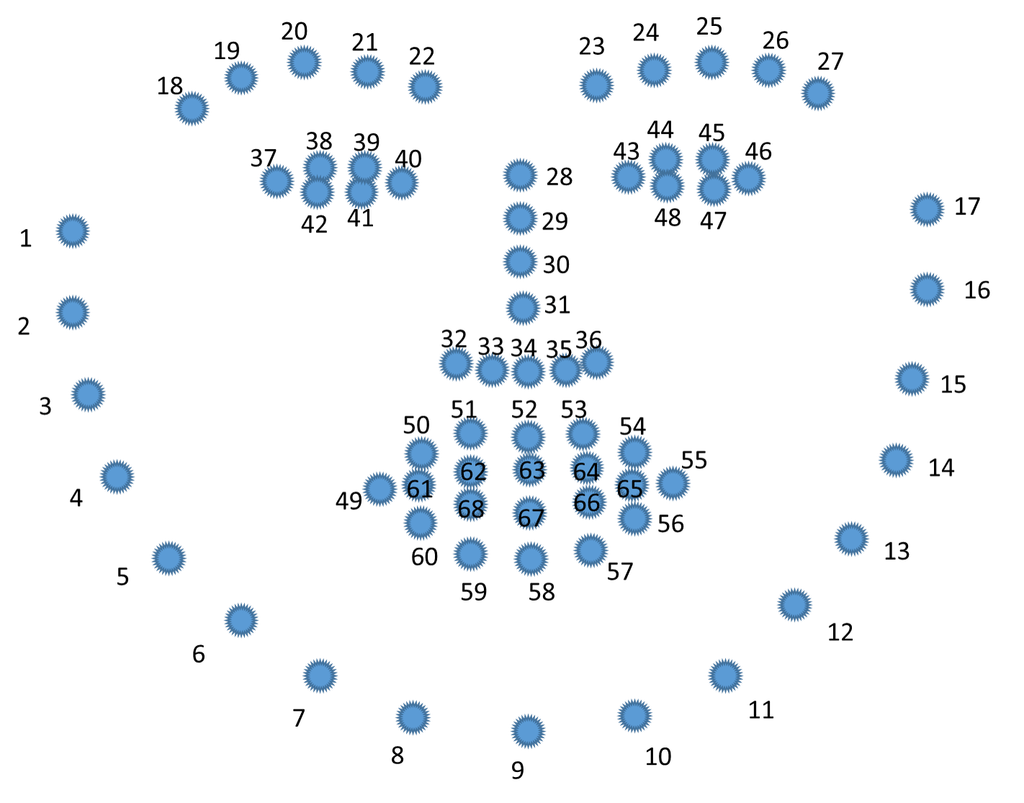

In [6]:
# 68개의 landmark
from IPython.display import Image
Image('/content/drive/MyDrive/metasoul/MagFace/image/68landmark.png', height = 300, width = 300)

# 직접 해보니까 아래 번호랑 좀 다르게 부여해야 함. -> 숫자가 0부터 시작해야 해서 1씩 빼야 함.

In [7]:
cd "/content/drive/MyDrive/metasoul/MagFace"

/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace


In [8]:
# 랜드마크 탐지기 load
face_detector = dlib.get_frontal_face_detector() # 정면 사진을 가지고 detection하겠다
landmark_detector = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") # 68개의 점을 가지고 옴.

- 5개의 점만 찾아주는 버전(shape_predictor_5_face_landmarks.dat)으로 구하면 어떻게 돌아가는지 확인하기  
    norm_crop을 적용하면 얼굴의 정면을 찾아주지 못함.

### Reading the image

In [9]:
def read_img(img_path):
    #read with dlib 
    img = dlib.load_rgb_image(img_path) 
    # img_for_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #read with opencv 
    # img = cv2.imread(img_path)[:,:,::-1]

    # return img, img_for_show
    return img

### face detection & landmark detections

In [10]:
# 이미지 별로 랜드마크와 route를 찾아줌.
def route_landmark_5_detection(img_path):
    # read_img
    img = read_img(img_path)

    # face_detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector(gray, 1) # upscale: 한 번을 하면 큰 이미지를 인식함.

    # route & landmark detection
    route_list = []
    landmark_list = []
    RIGHT_EYE = list(range(36, 42))
    LEFT_EYE = list(range(42, 48))
    EYES = list(range(36, 48))
    ROUTES = list(range(17, 27)) + [11, 5]

    for k, d in enumerate(faces):  # 얼굴마다
        landmarks = landmark_detector(gray, d) 
        # route detection: 회전시켰을 때 route의 x, y를 결정할 점의 좌표
        for n in ROUTES: 
            x = landmarks.part(n).x 
            y = landmarks.part(n).y 
            route_list.append([x, y]) 

        # landmark detection
        # 오른쪽 눈
        x_right_sum = 0
        y_right_sum = 0
        for n in RIGHT_EYE:
            x_right_sum += landmarks.part(n).x 
            y_right_sum += landmarks.part(n).y 

        x_right = int(x_right_sum / 6)
        y_right = int(y_right_sum / 6)
        right_eye_center = [x_right, y_right]
        landmark_list.append(right_eye_center) 
        # cv2.circle(img_for_show, (x_right, y_right), 2, (255, 255, 0), -1)

        # 왼쪽 눈
        x_left_sum = 0
        y_left_sum = 0
        for n in LEFT_EYE:
            x_left_sum += landmarks.part(n).x 
            y_left_sum += landmarks.part(n).y 

        x_left = int(x_left_sum / 6)
        y_left = int(y_left_sum / 6)
        left_eye_center = [x_left, y_left]
        landmark_list.append(left_eye_center) 
        # cv2.circle(img_for_show, (x_left, y_left), 2, (255, 255, 0), -1)

        # 코: 33, 입, 48, 54
        for n in [33, 48, 54]: 
            x = landmarks.part(n).x 
            y = landmarks.part(n).y 
            landmark_list.append([x, y]) 
            # cv2.circle(img_for_show, (x, y), 2, (255, 255, 0), -1)

    # for i in range(0, len(route_list)-1): 
    #     from_coordinate = tuple(route_list[i])
    #     to_coordinate = tuple(route_list[i+1]) 
    #     img_for_show = cv2.line(img_for_show, from_coordinate, to_coordinate, (255, 255, 0), 1)

    route_array = np.array(route_list)
    landmark_array = np.array(landmark_list)
    return route_array, landmark_array, gray

In [11]:
# route_landmark_5_detection('/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/jiho/jiho3.jpg')

### Align images to 112x112 pixels
face_align.py  
https://github.com/deepinsight/insightface/blob/cdc3d4ed5de14712378f3d5a14249661e54a03ec/python-package/insightface/utils/face_align.py  

In [12]:
sys.path.append("/content/drive/MyDrive/metasoul/MagFace")
import face_align_modified

**# 얼굴 외 공간이 너무 많이 포함된 듯함. -> route 만들어서 자르기**

In [13]:
# norm_crop: 얼굴 부분만 자르고, 얼굴 돌림.
def face_alignment(img_path):
    img_route_array, img_landmark_array, img_gray = route_landmark_5_detection(img_path)
    out = face_align_modified.norm_crop(img_gray, img_route_array, img_landmark_array)
    out = cv2.equalizeHist(out)
    return out

In [14]:
def read_all_file(path): 
    output = os.listdir(path) 
    file_list = [] 
    
    for i in output: 
        if os.path.isdir(path+"/"+i): 
            file_list.extend(read_all_file(path+"/"+i)) 
        elif os.path.isfile(path+"/"+i): 
            file_list.append(path+"/"+i) 
            
    return file_list

In [15]:
# 오마이걸
omg_list = read_all_file('/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl')
omg_list

['/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/arin/arin2.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/arin/arin3.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/arin/arin5.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/arin/arin4.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/arin/arin1.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/hyojung/hyojung1.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/hyojung/hyojung2.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/hyojung/hyojung3.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/hyojung/hyojung5.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/hyojung/hyojung4.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/jiho/jiho1.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/jiho/jiho2.png',
 '/content/drive/MyDri

#### 이미지 새로 저장
1. train_list, run.sh 돌리면 저장되는 경로, img.txt, 학습 log 저장되는 경로 다 다시 지정해야 함.  
2. 파라미터 수가 맞는지 확인  


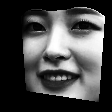

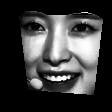

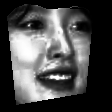

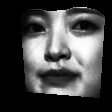

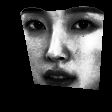

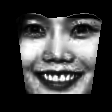

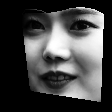

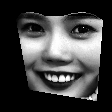

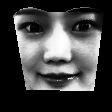

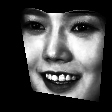

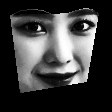

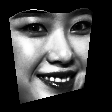

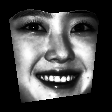

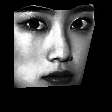

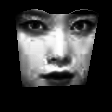

In [16]:
omg_train_lst = []
for i, path in enumerate(omg_list):
    aligned_img = face_alignment(path)
    cv2_imshow(aligned_img)
    print()
    save_path_name = '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/{}.jpg'.format(i)
    omg_train_lst.append(save_path_name)
    # cv2.imwrite(save_path_name, aligned_img) # 이미지 저장

### Prepare a training list with format 'imgname id 0' in each line (id starts from 0)  

In [17]:
# %cd /content/drive/MyDrive/metasoul/face_data

# !unzip -qq "/content/drive/MyDrive/metasoul/High_Resolution_compressed.zip"

In [18]:
train_list = []
omg_img_list = []
identity_id = 0 

# 400명, 한 사람 당 300개의 이미지
for i, src_path in enumerate(omg_train_lst):
    if (i != 0) and (i % 5 == 0):
        identity_id += 1
    file = src_path
    omg_img_list.append('{}'.format(file))
    train_list.append('{} id {}'.format(file, identity_id))

In [19]:
train_list

['/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/0.jpg id 0',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/1.jpg id 0',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/2.jpg id 0',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/3.jpg id 0',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/4.jpg id 0',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/5.jpg id 1',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/6.jpg id 1',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/7.jpg id 1',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/8.jpg id 1',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/9.jpg id 1',
 '/content/drive/MyD

In [26]:
omg_img_list

['/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/0.jpg',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/1.jpg',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/2.jpg',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/3.jpg',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/4.jpg',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/5.jpg',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/6.jpg',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/7.jpg',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/8.jpg',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg_image/9.jpg',
 '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/Mag

In [27]:
# # omg_img_list를 txt 파일로 저장하기
# with open('/content/drive/MyDrive/metasoul/MagFace/MagFace/omg_feature/img.txt','w',encoding='UTF-8') as f:
#     for name in omg_img_list:
#         f.write(name+'\n')

In [21]:
# # train_list를 txt 파일로 저장하기
# with open('/content/drive/MyDrive/metasoul/MagFace/MagFace/omg_feature/omg.txt','w',encoding='UTF-8') as f:
#     for name in train_list:
#         f.write(name+'\n')

## Modify parameters in run.sh/run_dist.sh/run_dist_cos.sh and run it.

In [22]:
cd "/content/drive/MyDrive/metasoul/MagFace/MagFace/run"

/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/MagFace/run


In [23]:
# !chmod +x run.sh

In [24]:
# %%sh
# /content/drive/MyDrive/metasoul/MagFace/MagFace/run/run.sh
# dist 붙은 거는 GPU 여러 개 필요한 듯 

In [25]:
# save되는 path 다르게 설정하기
!bash /content/drive/MyDrive/metasoul/MagFace/MagFace/run/run.sh

=> parse the args ...
{'arc_scale': 64,
 'arch': 'iresnet50',
 'batch_size': 512,
 'embedding_size': 512,
 'epochs': 25,
 'l_a': 10.0,
 'l_margin': 0.45,
 'lambda_g': 35.0,
 'last_fc_size': 85742,
 'lr': 0.1,
 'lr_drop_epoch': [10, 18, 22],
 'lr_drop_ratio': 0.1,
 'momentum': 0.9,
 'print_freq': 100,
 'pth_save_epoch': 1,
 'pth_save_fold': './test/',
 'start_epoch': 0,
 'train_list': '/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/MagFace/omg_feature/omg.txt',
 'u_a': 110.0,
 'u_margin': 0.8,
 'vis_mag': 1,
 'weight_decay': 0.0005,
 'workers': 8}
min lambda g is 22.586666666666673, currrent lambda is 35.0
=> torch version : 1.11.0+cu113
=> ngpus : 1
=> modeling the network ...
=> building the oprimizer ...
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)
=> building the dataloader ...
=> building the criterion ...
=> starting training engine ...
 : save pth for epoch 1
 : 

In [28]:
cd '/content/drive/MyDrive/metasoul/MagFace/MagFace/inference'

/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/MagFace/inference


https://issueantenna.com/repo/IrvingMeng/MagFace/issues/36

In [31]:
!python3 gen_feat.py --arch iresnet50 --inf_list /content/drive/MyDrive/metasoul/MagFace/MagFace/omg_feature/img.txt --feat_list /content/drive/MyDrive/metasoul/MagFace/MagFace/omg_feature/feat.txt --resume /content/drive/MyDrive/metasoul/MagFace/MagFace/omg_feature/omg_log/00025.pth

=> parse the args ...
=> parse the args ...
{'arch': 'iresnet50',
 'batch_size': 256,
 'cpu_mode': False,
 'dist': 1,
 'embedding_size': 512,
 'feat_list': '/content/drive/MyDrive/metasoul/MagFace/MagFace/omg_feature/feat.txt',
 'inf_list': '/content/drive/MyDrive/metasoul/MagFace/MagFace/omg_feature/img.txt',
 'print_freq': 100,
 'resume': '/content/drive/MyDrive/metasoul/MagFace/MagFace/omg_feature/omg_log/00025.pth',
 'workers': 4}
=> torch version : 1.11.0+cu113
=> ngpus : 1
=> modeling the network ...
=> loading pth from /content/drive/MyDrive/metasoul/MagFace/MagFace/omg_feature/omg_log/00025.pth ...
=> building the dataloader ...
=> preparing dataset for inference ...
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation mi